In [99]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.integrate import trapezoid

In [115]:
def pk_po(t: float, F: float, D: float, ka: float, k: float, V: float) -> float:
    return F * D * ka / (V * (ka - k)) * (np.exp(-k * t) - np.exp(-ka * t))


Zaszumione dane dla podania doustnego

Text(0.5, 0, 'Czas')

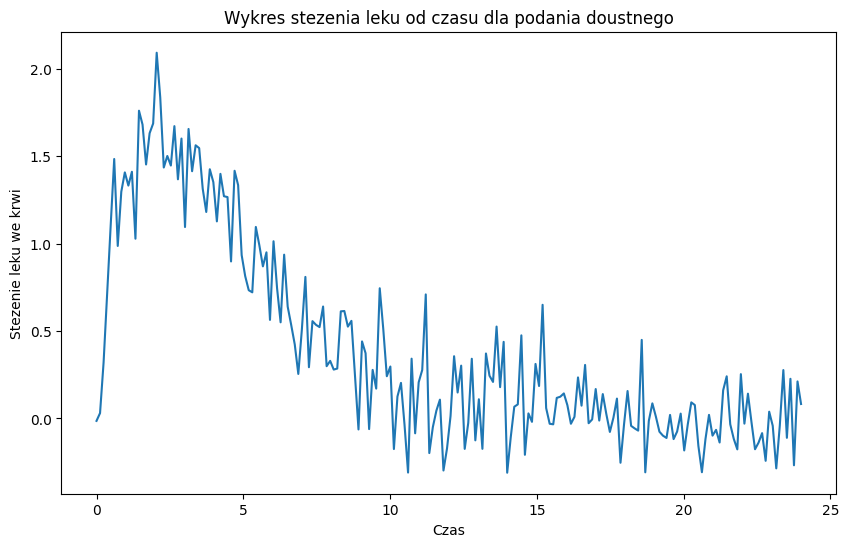

In [132]:
t = np.linspace(0, 24, 200)
params = dict(F = 0.1, D = 400, ka = 0.77, k = 0.31, V=12.6)
C = pk_po(t, **params) + 0.2*np.random.randn(t.size)

plt.figure(figsize=(10, 6))
plt.plot(t, C)
plt.title("Wykres stezenia leku od czasu dla podania doustnego")
plt.ylabel("Stezenie leku we krwi")
plt.xlabel("Czas")

Zgadywanie parametrow 

Fitted params: [7.92525940e-01 4.16730504e+02 7.98389309e-01 3.07093857e-01
 1.44600891e+01]


Text(0.5, 0, 'Czas')

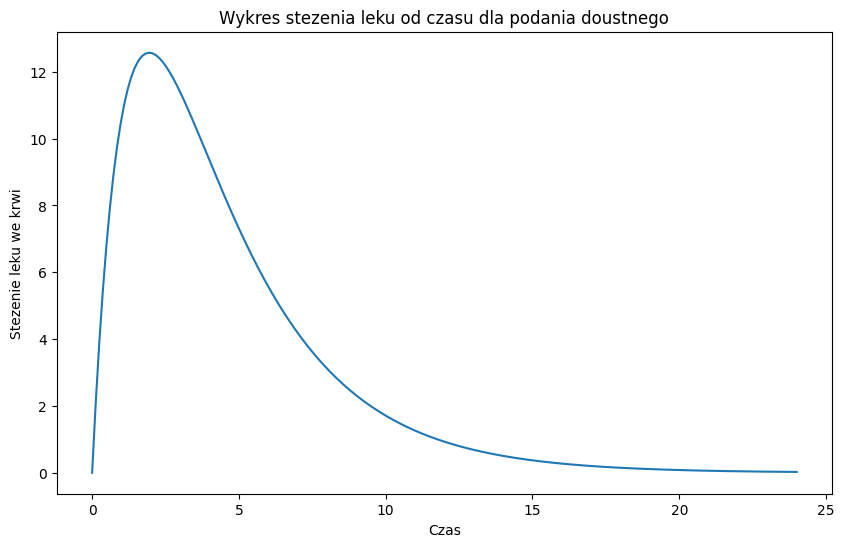

In [131]:
p0 = [0.7, 350, 0.7, 0.3, 12]
popt,_ = curve_fit(pk_po, t, C, p0=p0)
print('Fitted params:', popt)

C1 = pk_po(t, popt[0], popt[1], popt[2], popt[3], popt[4])

plt.figure(figsize=(10, 6))
plt.plot(t, C1)
plt.title("Wykres stezenia leku od czasu dla podania doustnego")
plt.ylabel("Stezenie leku we krwi")
plt.xlabel("Czas")

In [103]:
Cmax = C1.max()
temp = C1.argmax()
Tmax = t[temp]


print(Cmax)
print(Tmax)

12.510923932244724
1.92964824120603


In [104]:
def get_t_half(t: np.array, C: np.array, C_max: float) -> float | None:
    half_C = C_max / 2
    for i in range(len(C)-1):
        if C[i] >= half_C > C[i+1]:
            t_half = t[i] + (half_C - C[i]) * (t[i+1] - t[i]) / (C[i+1] - C[i])
            return t_half
    return None

Thalf = get_t_half(t, C1, Cmax)
print(Thalf)

5.614234323319925


In [105]:
auc = trapezoid(pk_po(t, *popt), t, dx=t[1]-t[0])
print(auc)

74.5128420524624


zadanie

In [106]:
def bolus(t, C0, k):
    Ct = C0 * np.exp(-k * t)
    return Ct

In [107]:
def wlew(t, R0, V, k):
    Css = R0/(k*V)
    Ct = Css * (1 - np.exp(-k * t))
    return Ct

In [108]:
# Wygenerowane przez chat na podstawie zdjecia
leki = {
    'ibuprofen': {
        'ka': 0.77,      # [h^-1]
        'k': 0.31,       # [h^-1]
        'F': 0.73,       # [-]
        'D': 400,        # [mg]
        'V': 12.6        # [l]
    },
    'escitalopram': {
        'ka': 0.81,      # [h^-1]
        'k': 0.023,      # [h^-1]
        'F': 0.8,        # [-]
        'D': 10,         # [mg]
        'V': 840         # [l]
    },
    'lowastatyna': {
        'ka': 2.57,      # [h^-1]
        'k': 0.139,      # [h^-1]
        'F': 0.05,       # [-]
        'D': 20,         # [mg]
        'V': 100         # [l]
    }
}

Text(0.5, 0, 'Czas[h]')

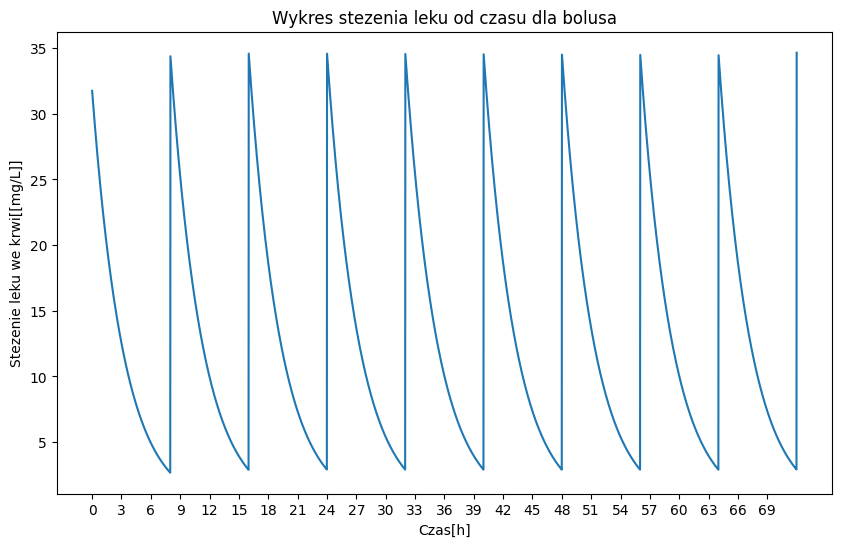

In [109]:
t = np.linspace(0, 72, 3600)
C_total = np.zeros_like(t)

godzina_bolusa = np.linspace(0, 72, 10)

for start_time in godzina_bolusa:
    t_shifted = t - start_time
    C_single = bolus(t_shifted, (leki['ibuprofen']['D']/leki['ibuprofen']['V']), leki['ibuprofen']['k'])
    
    # minusowe czasy na zero
    C_single[t_shifted < 0] = 0
    
    C_total = C_total + C_single

plt.figure(figsize=(10,6))
plt.plot(t, C_total)
plt.xticks(np.arange(0, 72, 3))
plt.title("Wykres stezenia leku od czasu dla bolusa")
plt.ylabel("Stezenie leku we krwi[[mg/L]]")
plt.xlabel("Czas[h]")

In [110]:
Cmax_bolus = C_total.max()
Tmax_bolus = t[C_total.argmax()]

print(Cmax_bolus)
print(Tmax_bolus)

Thalf_bolus = get_t_half(t, C_total, Cmax_bolus)
print(Thalf_bolus)

auc_bolus = trapezoid(C_total, t, dx=t[1]-t[0])
print(auc_bolus)

34.64752745322006
72.0
1.9538478509815418
912.6168775995634


Text(0.5, 0, 'Czas[h]')

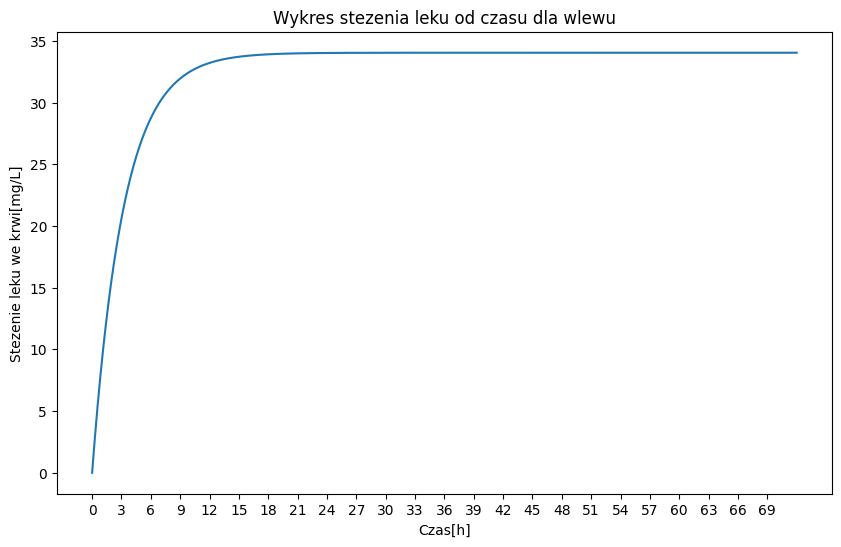

In [111]:
t = np.linspace(0, 72, 3600)
C = wlew(t, 133, leki['ibuprofen']['V'], leki['ibuprofen']['k'])

plt.figure(figsize=(10, 6))
plt.plot(t, C)
plt.xticks(np.arange(0, 72, 3))
plt.title("Wykres stezenia leku od czasu dla wlewu")
plt.ylabel("Stezenie leku we krwi[mg/L]")
plt.xlabel("Czas[h]")

In [112]:
Cmax_wlew = C.max()
Tmax_wlew = t[C.argmax()]

print(Cmax_wlew)
print(Tmax_wlew)

Thalf_wlew = get_t_half(t, C, Cmax_wlew)
print(Thalf_wlew)

auc_wlew = trapezoid(C, t, dx=t[1]-t[0])
print(auc_wlew)

34.05017920457243
72.0
None
2341.77326342194


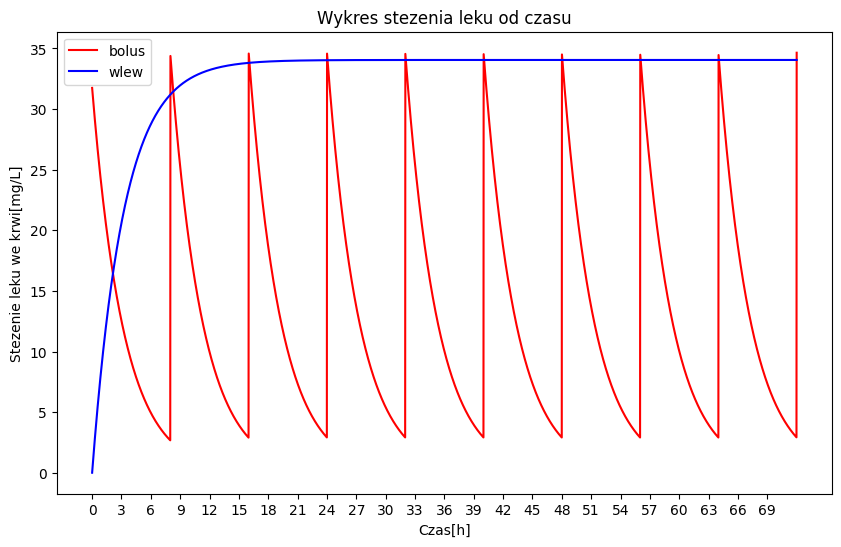

In [114]:
plt.figure(figsize=(10, 6))
plt.plot(t, C_total, label='bolus', color='red')
plt.plot(t, C, label='wlew', color='blue')
plt.xticks(np.arange(0, 72, 3))
plt.title("Wykres stezenia leku od czasu")
plt.ylabel("Stezenie leku we krwi[mg/L]")
plt.xlabel("Czas[h]")
plt.legend()